# I) Парсинг

Подгружаем нужные библиотеки

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

Собираем ссылки на объявления

In [ ]:
links = []
for i in range(100):
    #будем рабоать со страницей + номер страницы:
    link = 'https://moscow.drom.ru/auto/all/page' + str(i)
    
    #для начала отправляем запрос
    responce = requests.get(link).text

    #создаем объект (в качестве аргументов - значение аштимл и с помощью классов мы можем находить нужное значение на странице)
    soup = bs(responce, 'lxml')

    #достаем наш блок с данными, на странице объявления в нескольких блоках, поэтому будем использовать find_all
    block = soup.find_all('div', class_ = "css-1nvf6xk eojktn00")
    
    #служебный массив
    mass = []
    
    #перебираем в block и ищем наш разделитель - а, в нем получаем href и записываем в служебный массив
    for i in block:
        a = i.find_all('a')
        for j in a:
            mass.append(j.get('href'))
            
    #срезаем лишнее
    mass = mass[:20]
    
    #записываем наши ссылки в конечный массив
    for i in mass:
        links.append(i)

In [ ]:
#создаем нашу таблицу
df = pd.DataFrame(columns = ['Название', 
                             'Год', 
                             'Топливо', 
                             'Объем двигателя', 
                             'Мощность', 
                             'Коробка передач', 
                             'Привод', 
                             'Цвет', 
                             'Пробег',
                             'Руль',
                             'Оценка Drom',
                             'Цена'])

In [ ]:
#собираем данные с объявлений и вносим все в таблицу

#перебираем все ссылки в нашем массиве и создаем наш soup для каждой ссылки
for link in links:
    responce = requests.get(link).text
    soup = bs(responce, 'lxml')
    
    #проверяем не снято ли объявление с продажи, если снято - проходим мимо
    if 'Автомобиль снят с продажи' in str(soup.find('div', class_ = 'css-1bw6vfx edsrp6u2')):
        continue 
    #находим в soup блок с характеристиками и переделываем в строку
    block = str(soup.find('tbody'))

    #определяем название и год
    col = str(soup.find('span', class_ = 'css-1kb7l9z e162wx9x0'))[44:-20].split(', ')
    #случается такое, что по воле божей питон перестает на некоторых объявлениях видеть название. ограничиваем это
    if len(col) == 1:
        continue
    name = col[0]                     #название
    year = int(col[1])                   #год

    #работаем с данными по двигателю
    idx = block.find('Двигатель')
    if idx != -1: 
        engine = block[idx:]
        engine = engine[523:]
        engine = engine[:engine.find('<')]
    else:
        engine = ''
    if 'ГБО' in engine:
        engine = engine[:-5]
    if 'гибрид' in engine:
        engine = engine[:-8]
    mass_fuel = ['бензин', 'дизель', 'электро']
    fuel = ''
    for i in mass_fuel:
        if i in engine:
            fuel = i                                                #здесь определили топливо
            engine = engine.replace(i, '')[2:]
    if len(engine) != 0:
        volume = float(engine[:-2])                                 #здесь объем
    else:
        volume = ''


    #работаем по мощности
    power = block[block.find('Мощность'):]
    power = power[power.find('class="css-9g0qum e162wx9x0">'):][29:]
    power = power[:power.find('<!')]
    if len(power) >= 1:
        if power[0].isdigit() and power[-1].isdigit():
            power = int(power)
    else:
        power = ''

    #работаем по коробке передач
    idx = block.find('Коробка передач')
    transmission = ''
    if idx != -1: 
        transmission = block[idx:][52:]
        transmission = transmission[:transmission.find('<')]

    #определяем привод
    idx = block.find('Привод')
    drive = ''
    if idx != -1: 
        drive = block[idx:][43:]
        drive = drive[:drive.find('<')]

    #определяем цвет
    idx = block.find('Цвет')
    color = ''
    if idx != -1: 
        color = block[idx:][41:]
        color = color[:color.find('<')]

    #определяем руль
    idx = block.find('Руль')
    wheel = ''
    if idx != -1: 
        wheel = block[idx:][41:]
        wheel = wheel[:wheel.find('<')]

    #определяем пробег
    block = soup.find('span', class_ = 'css-1osyw3j ei6iaw00')
    mileage_mass = str(block)[35:-7].split('\xa0')

    mileage = ''
    for i in mileage_mass:
        mileage += i

    for i in mileage:
        if i.isdigit() == False:
            mileage = mileage[:mileage.find('i')]

    #определяем цену
    price_prep = str(soup.find('div', class_ = 'css-eazmxc e162wx9x0'))[34:-24].split('\xa0')
    price = ''
    for i in price_prep:
        price += i
    price = int(price)

    #определяем оценку авто по мнению дром
    score = str(soup.find('div', direction='column', class_ = 'css-obi42x eb0sjjd0'))[239:-6]

    #записываем собранные данные в список
    mass = [name, year, fuel, volume, power, transmission, drive, color, mileage, wheel, score, price]
    #добавляем список к таблице
    df.loc[len(df.index)] = mass

In [ ]:
#сохраняем нашу таблицу
df.to_csv('auto3.csv')

# II) Обработка данных

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_a = pd.read_csv('auto.csv', index_col=[0])
df_b = pd.read_csv('auto1.csv', index_col=[0])
df_c = pd.read_csv('auto2.csv', index_col=[0])
df_d = pd.read_csv('auto3.csv', index_col=[0])
# index_col=[0] чтобы не было лишнего столбца unnamed: 0

Создаем дополнительный датафрейм, который не будем изменять, чтобы сверяться, если что-то пойдет не так

In [3]:
df_1 = pd.read_csv('auto.csv', index_col=[0])
df_2 = pd.read_csv('auto1.csv', index_col=[0])
df_3 = pd.read_csv('auto2.csv', index_col=[0])
df_4 = pd.read_csv('auto3.csv', index_col=[0])

In [4]:
df = pd.concat([df_a, df_b, df_c, df_d], ignore_index=True) # соединяем четыре датафрейма
df1 = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [5]:
#во-первых, встречаются дубликаты из-за перекупов-дудосатакеров на дроме. Исправляем:
df.drop_duplicates(inplace = True, ignore_index = True ) #перезаписываем и сбрасываем индексы
df1.drop_duplicates(inplace = True, ignore_index = True )

In [6]:
#во время парсинга пустые значения заполнялись пустой строкой, по факту это - NaN. Заменим на настоящие NaN
df.replace('', np.NaN, inplace = True) #сразу перезаписываем таблицу
df1.replace('', np.NaN, inplace = True)

### Что за данные получились?

In [7]:
df.head()

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
0,Kia Mohave,2020,дизель,3.0,260.0,автомат,4WD,серый,26000.0,левый,8.8,4650000
1,Hyundai Santa Fe,2018,дизель,2.2,200.0,АКПП,4WD,серый,81000.0,левый,8.7,2850000
2,Toyota RAV4,2022,бензин,2.0,173.0,вариатор,4WD,черный,1.0,левый,8.7,4000000
3,Jeep Gladiator,2020,бензин,3.6,285.0,АКПП,4WD,черный,15000.0,левый,NaN,6750000
4,Jeep Wrangler,2018,бензин,2.0,272.0,АКПП,4WD,черный,37700.0,левый,8.7,5200000


In [8]:
df.describe()

,Год,Объем двигателя,Мощность,Пробег,Оценка Drom,Цена
count,1390.000000,1375.000000,1337.000000,1101.000000,853.000000,1.390000e+03
mean,2016.328777,2.170255,187.021690,112515.642144,8.601524,3.162654e+06
std,6.463318,0.824389,98.842305,81255.735399,0.275587,3.823350e+06
min,1950.000000,0.700000,46.000000,1.000000,7.500000,4.300000e+04
25%,2013.000000,1.600000,123.000000,51000.000000,8.500000,1.095000e+06
50%,2018.000000,2.000000,152.000000,102230.000000,8.700000,1.950000e+06
75%,2021.000000,2.500000,211.000000,155314.000000,8.800000,3.782324e+06
max,2023.000000,6.500000,800.000000,521208.000000,8.900000,2.900000e+07


Ого! На дроме даже продают раритетные тачки!

In [9]:
df.loc[df['Год'] == 1950]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
905,BMW 340,1950,бензин,2.0,55.0,механика,задний,черный,50000.0,левый,NaN,5600000


![Раритетное авто](https://s836sas.storage.yandex.net/rdisk/afbb86bc102543af988ecfbed45f77515ad953ac726a4723488c47198a04f461/659ecc18/fKqInKw3d7bLFOeFnMGnhBzWLnpQfvB4P8-ya8uUT27Mr85sOOhcWRD_V1rjKvPY6mcW70XC39gH7kQeQCqCBkMhQVWKnMQSPhZP5O4ivVar8npumZHI4midPdWhecNq?uid=1130000060110486&filename=Unknown.jpg&disposition=inline&hash=&limit=0&content_type=image%2Fjpeg&owner_uid=1130000060110486&fsize=123159&hid=0b74feeff34c00c8364fa577bc396303&media_type=image&tknv=v2&etag=7099074cfb3b74048fa18af147bd2f88&rtoken=Q2meNYRJ1eA2&force_default=yes&ycrid=na-5ffd792ea5dc0f4f68589f63a2c739b6-downloader24f&ts=60e9a4db93600&s=c35ae5451f9beb98d72b3c625eb9432ea766e3b21485d790d8702579e722ff14&pb=U2FsdGVkX1-VLZVhagiNOvOkZmb2bVHt-KWHfQV6ky-xuTVPYjfXAGgALvTqfnRT4RJWOCmwbM7_1DoLHRYd4g7r6sLQ_Cfbtk80BjNVI-v0-JU5fYGyPU18MSQz5DsV)

Посмотрим, сколько NaNов в столбцах

In [10]:
df1.isnull().sum()

Название             0
Год                  0
Топливо             15
Объем двигателя     15
Мощность            53
Коробка передач     21
Привод              23
Цвет               141
Пробег             289
Руль                 9
Оценка Drom        537
Цена                 0
dtype: int64

Глянем более наглядно на заполненность данных по столбцам

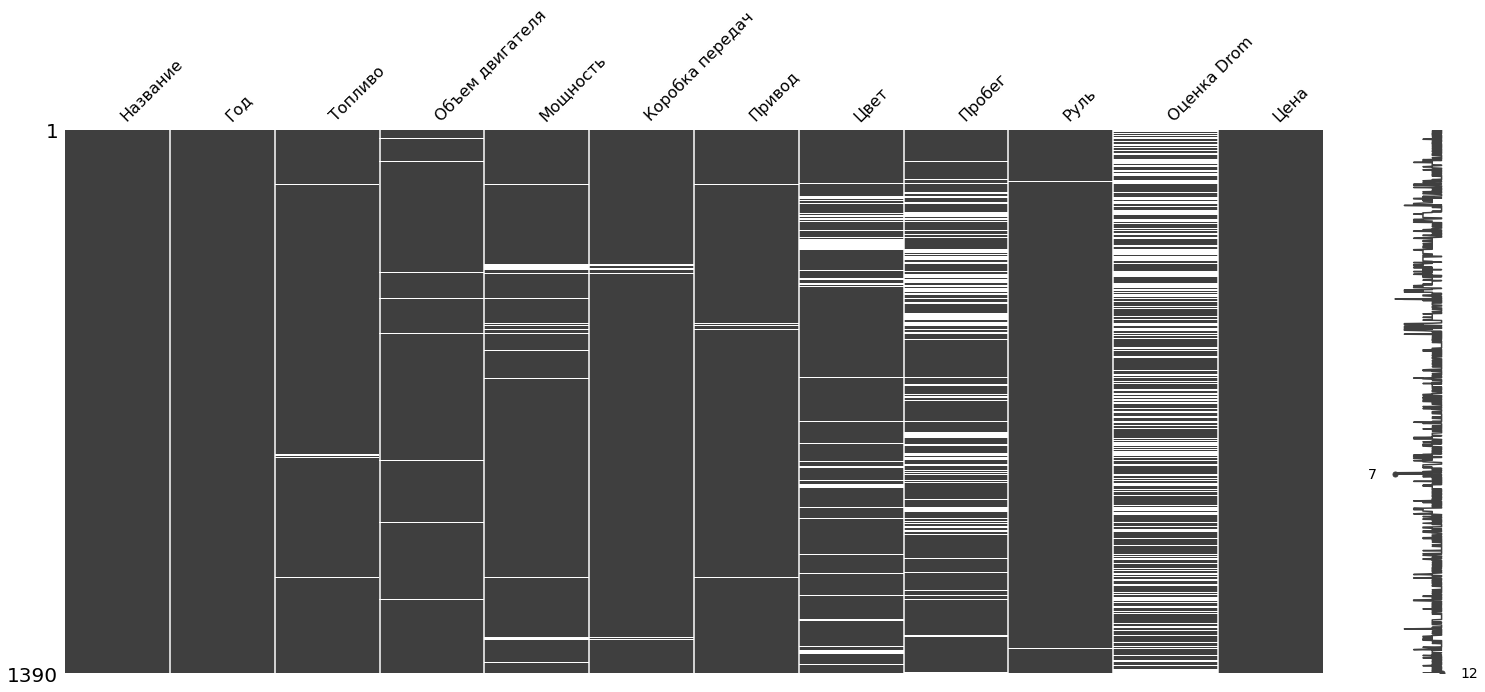

In [13]:
msno.matrix(df);

Видно, что больше всего пропусков встречаются в Оценке Drom, Пробеге и Цвете

## Начнем с пробега

Есть подозрение, что пропуски в пробеге говорят о том, что там просто новые машинки, которые еще не успели поездить

Проверим это по году выпуска? Будем считать, что право на нулевой пробег имеют только машины от 2022 года выпуска и младше

In [14]:
df1[(df1['Пробег'].isna()) & (df1['Год']<2022)]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
172,Volkswagen Polo,2019,бензин,1.6,110.0,АКПП,передний,NaN,NaN,левый,8.6,1100000
175,Toyota Land Cruiser,2007,дизель,4.5,235.0,АКПП,4WD,NaN,NaN,левый,NaN,2200000
176,Mercedes-Benz S-Class,2015,бензин,3.0,333.0,АКПП,4WD,NaN,NaN,левый,NaN,2400000
178,Hyundai Getz,2008,бензин,1.4,97.0,АКПП,передний,красный,NaN,левый,8.3,425000
179,Mercedes-Benz GLE Coupe,2015,бензин,3.0,333.0,АКПП,4WD,красный,NaN,левый,NaN,3400000
342,Audi Q7,2021,дизель,3.0,249.0,АКПП,4WD,синий,NaN,левый,NaN,13610000
343,Mercedes-Benz S-Class,2021,бензин,3.0,367.0,АКПП,4WD,серебристый,NaN,левый,NaN,23148730
384,Hyundai Santa Fe,2021,дизель,2.2,199.0,робот,4WD,NaN,NaN,левый,8.7,5357000
398,Mercedes-Benz S-Class,2021,дизель,2.9,249.0,АКПП,4WD,NaN,NaN,левый,NaN,23740000
400,Mercedes-Benz S-Class,2021,дизель,2.9,249.0,АКПП,4WD,черный,NaN,левый,NaN,22072000


Пробежимся по средним значениям для каждого года выпуска, присвоим нулевым пробегам эти значения соответственно

In [15]:
df.at [172, 'Пробег'] = df.loc[df['Год'] == 2019, 'Пробег'].mean()

In [16]:
df.at [342, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [384, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [398, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [470, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [494, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [876, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [879, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [898, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [1044, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()
df.at [1328, 'Пробег'] = df.loc[df['Год'] == 2021, 'Пробег'].mean()

In [17]:
df.at [175, 'Пробег'] = df.loc[df['Год'] == 2007, 'Пробег'].mean()
df.at [848, 'Пробег'] = df.loc[df['Год'] == 2007, 'Пробег'].mean()

In [18]:
df.at [176, 'Пробег'] = df.loc[df['Год'] == 2015, 'Пробег'].mean()

In [19]:
df.at [844, 'Пробег'] = df.loc[df['Год'] == 2002, 'Пробег'].mean()

In [20]:
df.at [178, 'Пробег'] = df.loc[df['Год'] == 2008, 'Пробег'].mean()

In [21]:
df[(df['Пробег'].isna()) & (df['Год']<2022)]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
179,Mercedes-Benz GLE Coupe,2015,бензин,3.0,333.0,АКПП,4WD,красный,NaN,левый,NaN,3400000
343,Mercedes-Benz S-Class,2021,бензин,3.0,367.0,АКПП,4WD,серебристый,NaN,левый,NaN,23148730
400,Mercedes-Benz S-Class,2021,дизель,2.9,249.0,АКПП,4WD,черный,NaN,левый,NaN,22072000
401,Mercedes-Benz S-Class,2021,дизель,2.9,249.0,АКПП,4WD,черный,NaN,левый,NaN,23634000
846,Kia Sorento,2002,дизель,2.5,145.0,АКПП,4WD,NaN,NaN,левый,8.6,530000


Остались только подозрительные строки дудоссеров, их удалим вообще

In [22]:
df.drop(axis=0, index=343, inplace=True)
df.drop(axis=0, index=400, inplace=True)
df.drop(axis=0, index=401, inplace=True)
df.drop(axis=0, index=846, inplace=True)

Ну вот, теперь все старые машины остались без нулевого пробега, сделаем новым пробег=0 вместо NaN

In [23]:
df['Пробег'].fillna(value=0, inplace=True)

## Следующим большим вопросом стала Оценка Drom. 

Там столько пропусков, что появляется желание ее удалить вообще... Однако, возможно, она нам еще пригодится...Заменим ее на среднее(8.602), тк по 10-балльной шкале, как выяснилось, минимум -- 7.5, а максимум -- 8.9, поэтому медиана(8.7) не так репрезентативна

In [24]:
df['Оценка Drom'].fillna(value=8.602, inplace=True)

## Отлично! Теперь разберемся с мощностью

In [26]:
df[(df['Мощность'].isna())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
130,Hyundai Solaris,2014,бензин,1.4,NaN,NaN,передний,серебристый,48950.00,левый,8.800,983000
141,Kia Sorento,2012,NaN,2.4,NaN,автомат,NaN,черный,205349.00,левый,8.600,1378000
147,Toyota Camry,2014,NaN,2.5,NaN,автомат,NaN,черный,234094.00,левый,8.800,1448000
339,Kia Sportage,2010,NaN,2.0,NaN,механика,NaN,серый,117600.00,левый,8.700,839000
344,Mazda Mazda6,2015,бензин,2.5,NaN,NaN,передний,белый,164036.00,левый,8.900,1520000
345,Volkswagen Tiguan,2017,бензин,1.4,NaN,NaN,передний,бежевый,105298.00,левый,8.602,1839000
346,Kia Rio,2021,бензин,1.6,NaN,NaN,передний,черный,53384.00,левый,8.700,1550000
347,Haval F7,2020,бензин,2.0,NaN,NaN,4WD,синий,41009.00,левый,8.602,2100000
348,SsangYong Kyron,2014,бензин,2.3,NaN,NaN,4WD,белый,166868.00,левый,8.100,950000
349,Kia Sportage,2016,бензин,2.0,NaN,NaN,передний,серый,142294.00,левый,8.700,1650000


In [27]:
df.drop(axis=0, index=359, inplace=True)
df.drop(axis=0, index=414, inplace=True)
df.drop(axis=0, index=433, inplace=True)
df.drop(axis=0, index=497, inplace=True)
df.drop(axis=0, index=496, inplace=True)
df.drop(axis=0, index=502, inplace=True)
df.drop(axis=0, index=505, inplace=True)
df.drop(axis=0, index=508, inplace=True)
df.drop(axis=0, index=510, inplace=True)
df.drop(axis=0, index=512, inplace=True)
df.drop(axis=0, index=522, inplace=True)
df.drop(axis=0, index=879, inplace=True)
df.drop(axis=0, index=876, inplace=True)
df.drop(axis=0, index=495, inplace=True)
df.drop(axis=0, index=344, inplace=True)
df.drop(axis=0, index=358, inplace=True)

Здесь опять на лицо куча дудос-строк, избавимся от них


In [28]:
df[(df['Мощность'].isna())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
130,Hyundai Solaris,2014,бензин,1.4,NaN,NaN,передний,серебристый,48950.0,левый,8.800,983000
141,Kia Sorento,2012,NaN,2.4,NaN,автомат,NaN,черный,205349.0,левый,8.600,1378000
147,Toyota Camry,2014,NaN,2.5,NaN,автомат,NaN,черный,234094.0,левый,8.800,1448000
339,Kia Sportage,2010,NaN,2.0,NaN,механика,NaN,серый,117600.0,левый,8.700,839000
345,Volkswagen Tiguan,2017,бензин,1.4,NaN,NaN,передний,бежевый,105298.0,левый,8.602,1839000
346,Kia Rio,2021,бензин,1.6,NaN,NaN,передний,черный,53384.0,левый,8.700,1550000
347,Haval F7,2020,бензин,2.0,NaN,NaN,4WD,синий,41009.0,левый,8.602,2100000
348,SsangYong Kyron,2014,бензин,2.3,NaN,NaN,4WD,белый,166868.0,левый,8.100,950000
349,Kia Sportage,2016,бензин,2.0,NaN,NaN,передний,серый,142294.0,левый,8.700,1650000
350,Kia Rio,2013,бензин,1.6,NaN,NaN,передний,черный,178421.0,левый,8.700,810000


Кажется логичным NaNовую мощность у Hyundai Solaris заменить на 123

In [29]:
df[(df['Мощность']!=0) & (df['Название']=='Hyundai Solaris')]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
130,Hyundai Solaris,2014,бензин,1.4,NaN,NaN,передний,серебристый,48950.0,левый,8.8,983000
205,Hyundai Solaris,2016,бензин,1.6,123.0,АКПП,передний,бежевый,33502.0,левый,8.8,1267000
226,Hyundai Solaris,2017,бензин,1.6,123.0,АКПП,передний,белый,142515.0,левый,8.8,1066000
237,Hyundai Solaris,2019,бензин,1.6,123.0,АКПП,передний,белый,82930.0,левый,8.8,1453000
249,Hyundai Solaris,2015,бензин,1.6,123.0,АКПП,передний,черный,174369.0,левый,8.8,900000
293,Hyundai Solaris,2016,бензин,1.6,123.0,АКПП,передний,NaN,98556.0,левый,8.8,1015000
303,Hyundai Solaris,2020,бензин,1.6,123.0,АКПП,передний,NaN,94585.0,левый,8.8,1445000
338,Hyundai Solaris,2018,бензин,1.6,123.0,АКПП,передний,белый,67405.0,левый,8.8,1428000
368,Hyundai Solaris,2019,бензин,1.6,NaN,NaN,передний,белый,71822.0,левый,8.8,1590000
504,Hyundai Solaris,2015,бензин,1.6,123.0,АКПП,передний,белый,123303.0,левый,8.8,999000


In [30]:
df.at [130, 'Мощность'] = 123.0
df.at [368, 'Мощность'] = 123.0

Проделываем то же для остальных марок

In [31]:
df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()

199.0

Заменим NaNовую мощность у Kia Sorento на медианную, тк она более выбросоустойчива, чем средняя, хотя они и очень близки

In [32]:
df.at [141, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()
df.at [1302, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()
df.at [1363, 'Мощность'] = df.loc[df['Название'] == 'Kia Sorento', 'Мощность'].median()

In [33]:
df.at [345, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()
df.at [362, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()
df.at [636, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Tiguan', 'Мощность'].median()

In [34]:
df.at [147, 'Мощность'] = df.loc[df['Название'] == 'Toyota Camry', 'Мощность'].median()

In [35]:
df.at [339, 'Мощность'] = df.loc[df['Название'] == 'Kia Sportage', 'Мощность'].median()
df.at [349, 'Мощность'] = df.loc[df['Название'] == 'Kia Sportage', 'Мощность'].median()

In [36]:
df.at [346, 'Мощность'] = df.loc[df['Название'] == 'Kia Rio', 'Мощность'].median()
df.at [350, 'Мощность'] = df.loc[df['Название'] == 'Kia Rio', 'Мощность'].median()

In [37]:
df.at [360, 'Мощность'] = df.loc[df['Название'] == 'Mitsubishi Pajero', 'Мощность'].median()
df.at [1366, 'Мощность'] = df.loc[df['Название'] == 'Mitsubishi Pajero', 'Мощность'].median()

In [38]:
df.at [347, 'Мощность'] = df.loc[df['Название'] == 'Haval F7', 'Мощность'].median()

In [39]:
df.at [348, 'Мощность'] = df.loc[df['Название'] == 'SsangYong Kyron', 'Мощность'].median()

In [40]:
df.at [351, 'Мощность'] = df.loc[df['Название'] == 'Nissan Juke', 'Мощность'].median()

А вот Volvo XC70 оказалась одной единственной машинкой этой марки, так что пришлось поискать в интернете, какая у нее могла бы быть мощность в теории

In [41]:
df.at [352, 'Мощность'] = 215

In [42]:
df.at [353, 'Мощность'] = df.loc[df['Название'] == 'Citroen Berlingo', 'Мощность'].median()

Peugeot Partner тоже найдем в интернетах

In [43]:
df.at [355, 'Мощность'] = 75

In [44]:
df.at [356, 'Мощность'] = df.loc[df['Название'] == 'Kia Ceed', 'Мощность'].median()

In [45]:
df.at [367, 'Мощность'] = df.loc[df['Название'] == 'Skoda Octavia', 'Мощность'].median()
df.at [789, 'Мощность'] = df.loc[df['Название'] == 'Skoda Octavia', 'Мощность'].median()

In [46]:
df.at [369, 'Мощность'] = df.loc[df['Название'] == 'Skoda Rapid', 'Мощность'].median()

In [47]:
df.at [409, 'Мощность'] = df.loc[df['Название'] == 'Changan UNI-K', 'Мощность'].median()

Changan CS95 тоже найдем в интернетах

In [48]:
df.at [411, 'Мощность'] = 233

Toyota Highlander	2022	бензин	тоже

In [49]:
df.at [432, 'Мощность'] = 244

Лада 2102 тоже :)

In [50]:
df.at [565, 'Мощность'] = 64

In [51]:
df.at [1145, 'Мощность'] = df.loc[df['Название'] == 'Ford Focus', 'Мощность'].median()
df.at [1304, 'Мощность'] = df.loc[df['Название'] == 'Ford Focus', 'Мощность'].median()

In [52]:
df.at [1299, 'Мощность'] = df.loc[df['Название'] == 'Nissan Pathfinder', 'Мощность'].median()

Audi Q8 тоже :)

In [53]:
df.at [637, 'Мощность'] = 340

In [54]:
df.at [786, 'Мощность'] = df.loc[df['Название'] == 'Volkswagen Golf', 'Мощность'].median()

In [55]:
df.at [1136, 'Мощность'] = df.loc[df['Название'] == 'Renault Duster', 'Мощность'].median()

Cadillac SRX тоже :)

In [56]:
df.at [1297, 'Мощность'] = 270

In [57]:
df.at [1301, 'Мощность'] = df.loc[df['Название'] == 'Audi A4', 'Мощность'].median()

In [58]:
# Все вышеперечисленные марки автомобилей мы проверяли через такую штучку, чтобы убедиться, что медиана существует и она репрезентативна
df[(df['Мощность']!=0) & (df['Название']=='...')]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена


# Что ж, теперь разберемся с объемами двигателей

In [60]:
df[(df['Объем двигателя'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
24,Mercedes-Benz EQV,2021,электро,NaN,204.0,АКПП,передний,черный,19690.0,левый,8.602,7890000
83,Rivian R1T,2022,электро,NaN,760.0,АКПП,4WD,зеленый,0.0,левый,8.602,15990000
94,Tesla Model X,2022,электро,NaN,670.0,автомат,4WD,белый,0.0,левый,8.400,11450000
366,BYD Yuan,2019,электро,NaN,163.0,автомат,передний,белый,55000.0,левый,8.602,2100000
432,Toyota Highlander,2022,бензин,NaN,244.0,автомат,4WD,NaN,0.0,левый,8.602,6990000
847,Nissan Leaf,2016,электро,NaN,109.0,АКПП,передний,белый,64000.0,правый,8.602,1019000
948,Evolute i-Joy,2022,электро,NaN,163.0,АКПП,передний,черный,0.0,левый,8.602,3490000
1005,Nissan Leaf,2014,электро,NaN,109.0,АКПП,передний,черный,70000.0,правый,8.602,800000
1075,BMW i7,2022,электро,NaN,544.0,автомат,4WD,черный,4200.0,левый,8.602,26690000
1083,BMW iX,2022,электро,NaN,523.0,АКПП,4WD,черный,10800.0,левый,8.602,10900000


Здесь очевидно собраны те машины, у которых двигатель заправляется не топливом, а электричеством. Поэтому их двигатель вообще не имеет объема. Единственным исключением стала Toyota Highlander на бензине, ее объем мы проверим в интернете. У электрокаров заменим объем на нули

In [61]:
df.at [432, 'Объем двигателя'] = 3.5

In [62]:
df['Объем двигателя'].fillna(value=0, inplace=True)

## Займемся топливом

In [63]:
df[(df['Топливо'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
141,Kia Sorento,2012,NaN,2.4,199.0,автомат,NaN,черный,205349.0,левый,8.600,1378000
147,Toyota Camry,2014,NaN,2.5,181.0,автомат,NaN,черный,234094.0,левый,8.800,1448000
339,Kia Sportage,2010,NaN,2.0,150.0,механика,NaN,серый,117600.0,левый,8.700,839000
786,Volkswagen Golf,2011,NaN,1.6,122.0,автомат,NaN,серый,124021.0,левый,8.700,779000
789,Skoda Octavia,2011,NaN,1.4,152.0,механика,NaN,серый,238627.0,левый,8.800,649000
831,Voyah Free,2023,NaN,1.5,693.0,автомат,4WD,голубой,0.0,левый,8.602,7490000
833,Voyah Free,2023,NaN,1.5,693.0,автомат,4WD,черный,0.0,левый,8.602,7490000
834,Voyah Free,2023,NaN,1.5,693.0,автомат,4WD,синий,0.0,левый,8.602,7490000
838,Voyah Free,2023,NaN,1.5,693.0,автомат,4WD,серый,0.0,левый,8.602,7490000
839,Voyah Free,2023,NaN,1.5,693.0,автомат,4WD,белый,0.0,левый,8.602,7490000


По статистике, более 80% автомобилей ездят на бензине. Поэтому вряд ли мы ошибемся, если заменим NaNы на "бензин"

In [64]:
df['Топливо'].fillna(value='бензин', inplace=True)

## Посмотрим на NaNы в коробке передач

In [65]:
df[(df['Коробка передач'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
130,Hyundai Solaris,2014,бензин,1.4,123.0,NaN,передний,серебристый,48950.0,левый,8.800,983000
345,Volkswagen Tiguan,2017,бензин,1.4,150.0,NaN,передний,бежевый,105298.0,левый,8.602,1839000
346,Kia Rio,2021,бензин,1.6,123.0,NaN,передний,черный,53384.0,левый,8.700,1550000
347,Haval F7,2020,бензин,2.0,190.0,NaN,4WD,синий,41009.0,левый,8.602,2100000
348,SsangYong Kyron,2014,бензин,2.3,141.0,NaN,4WD,белый,166868.0,левый,8.100,950000
349,Kia Sportage,2016,бензин,2.0,150.0,NaN,передний,серый,142294.0,левый,8.700,1650000
350,Kia Rio,2013,бензин,1.6,123.0,NaN,передний,черный,178421.0,левый,8.700,810000
352,Volvo XC70,2013,дизель,2.4,215.0,NaN,4WD,черный,247611.0,левый,8.602,1700000
356,Kia Ceed,2016,бензин,1.6,128.0,NaN,передний,черный,131773.0,левый,8.800,1380000
360,Mitsubishi Pajero,2008,бензин,3.8,174.0,NaN,4WD,черный,164507.0,левый,8.400,1500000


# Update

> ##### Изначально было так: "Было принято решение всем иномаркам старше 2010 года приписать автоматическую коробку передач, т.к. это очень даже соответсвует реалиям на рынке"

> #### Однако после комментария, полученного на чекпойнте, я решил более корректно заменить наны в этом случае. А именно: заменить на автомат не все наны подряд, а примерно пропорционально ситуации на рынке. Инфромацию погуглил и вот, что нашел:

>"В агентстве Автостат подсчитали, что по итогам первых девяти месяцев 2021 года доля машин с автоматическими трансмиссиями (включая вариаторы и «роботы») на российском рынке достигла 66% (771 тысяча машин). 

>"...Как оказалось, автомобили на "механике" составляют 36% от общего числа представленных в сервисе автомобилей."

#### Из 18 нановых строк сделаем 11 автоматом и 7 механикой. Причем пусть механикой будут наиболее старые тачки.

In [68]:
#df['Коробка передач'].fillna(value='автомат', inplace=True)
#df['Коробка передач'].fillna(value='механика', inplace=True)
# старый код

In [71]:
df.at [1302, 'Коробка передач'] = 'механика' #2006
df.at [360, 'Коробка передач'] = 'механика'   #2008
df.at [350, 'Коробка передач'] = 'механика'   #2013
df.at [352, 'Коробка передач'] = 'механика'   #2013
df.at [362, 'Коробка передач'] = 'механика'   #2013
df.at [1299, 'Коробка передач'] = 'механика' #2013 
df.at [130, 'Коробка передач'] = 'механика'   #2014

In [72]:
df['Коробка передач'].fillna(value='автомат', inplace=True)

А еще АКПП это и есть автомат, так что исправим это

In [74]:
df.loc[df['Коробка передач'] == 'АКПП', 'Коробка передач'] = 'автомат'

## А как там рули?

In [75]:
df[(df['Руль'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
134,Лада 2105,1997,бензин,1.5,71.0,механика,задний,зеленый,27000.0,NaN,8.602,68000
142,Лада 2110,1999,бензин,1.5,70.0,механика,передний,голубой,29131.0,NaN,7.600,500000
194,Volkswagen Atlas,2020,бензин,2.0,235.0,автомат,4WD,черный,26470.0,NaN,8.602,4200000
543,Лада 2107,2008,бензин,1.6,73.0,механика,задний,зеленый,90681.0,NaN,7.600,110000
570,Chevrolet Lanos,2005,бензин,1.5,86.0,механика,передний,черный,150000.0,NaN,7.500,150000
866,Lifan Smily,2011,бензин,1.3,89.0,механика,передний,красный,150000.0,NaN,8.100,130000
1106,Лада 2107,1987,бензин,1.5,71.0,механика,задний,бежевый,200000.0,NaN,7.600,43000
1224,Лада 2107,2011,бензин,1.6,74.0,механика,задний,NaN,58000.0,NaN,7.600,179000
1327,Infiniti M25,2012,бензин,2.5,222.0,автомат,задний,черный,147386.0,NaN,8.602,1800000


# Update

> ##### Изначально было так: "Очевидно, все праворульные машины скорее всего производят Японии и Великобритании. А в списке выше таких нет, поэтому можем по умолчанию исправить рули на левые"

> Однако проверяющий не согласился с теорией, так что проверю это все ручками в интернете.

> Результат научного ресёрча: ***(барабанная дробь)***
1. Лада 2105 - руль слева
2. Лада 2110 - руль слева
3. Лада 2107 - руль слева
4. Volkswagen Atlas - руль слева
5. Chevrolet Lanos - руль слева
6. Lifan Smily - руль слева
7. Infiniti M25 - может быть слева и справа, но конкретно это объявление на данный момент уже снято с продажи... Поэтому мы уже никогда не узнаем, какой там был руль. Но у всех Infiniti M25 2012 года той же комплектации руль находится слева

> Поэтому совершенно правомерным заменить все рули на левые

In [77]:
df['Руль'].fillna(value='левый', inplace=True)

## Привод


In [79]:
df[(df['Привод'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
141,Kia Sorento,2012,бензин,2.4,199.0,автомат,NaN,черный,205349.0,левый,8.600,1378000
147,Toyota Camry,2014,бензин,2.5,181.0,автомат,NaN,черный,234094.0,левый,8.800,1448000
193,УАЗ Буханка,2023,бензин,2.7,112.0,механика,NaN,NaN,0.0,левый,8.602,1333000
339,Kia Sportage,2010,бензин,2.0,150.0,механика,NaN,серый,117600.0,левый,8.700,839000
409,Changan UNI-K,2022,бензин,2.0,226.0,автомат,NaN,белый,0.0,левый,8.602,3939000
411,Changan CS95,2023,бензин,2.0,233.0,автомат,NaN,серый,0.0,левый,8.602,4290000
786,Volkswagen Golf,2011,бензин,1.6,122.0,автомат,NaN,серый,124021.0,левый,8.700,779000
789,Skoda Octavia,2011,бензин,1.4,152.0,механика,NaN,серый,238627.0,левый,8.800,649000
797,Skoda Rapid,2015,бензин,1.6,110.0,автомат,NaN,коричневый,204710.0,левый,8.602,600000
1136,Renault Duster,2015,бензин,1.5,114.0,механика,NaN,зеленый,109718.0,левый,8.300,1088000


Заменяем NaNовые приводы на самый популярный по определению тип привода

In [80]:
df['Привод'].fillna(value='передний', inplace=True)

## Цвет

In [81]:
df[(df['Цвет'].isnull())]

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
139,Лада Нива Тревел,2023,бензин,1.7,80.0,механика,4WD,NaN,0.000000,левый,8.602,1277000
158,Land Rover Range Rover Sport,2014,дизель,3.0,249.0,автомат,4WD,NaN,173000.000000,левый,8.602,2650000
172,Volkswagen Polo,2019,бензин,1.6,110.0,автомат,передний,NaN,74205.109827,левый,8.600,1100000
175,Toyota Land Cruiser,2007,дизель,4.5,235.0,автомат,4WD,NaN,232020.300000,левый,8.602,2200000
176,Mercedes-Benz S-Class,2015,бензин,3.0,333.0,автомат,4WD,NaN,137364.609756,левый,8.602,2400000
...,...,...,...,...,...,...,...,...,...,...,...,...
1340,Genesis G70,2019,бензин,2.0,197.0,автомат,4WD,NaN,88652.000000,левый,8.900,2070000
1341,Nissan Qashqai,2019,бензин,2.0,144.0,вариатор,передний,NaN,88798.000000,левый,8.600,1650000
1343,Audi Q3,2016,бензин,2.0,180.0,робот,4WD,NaN,115000.000000,левый,8.602,1850000
1351,BMW 5-Series,2021,дизель,2.0,190.0,автомат,4WD,NaN,36498.000000,левый,8.900,5195000


In [82]:
df['Цвет'].fillna(value='белый', inplace=True) # тут, к сожалению, не угадаешь...

### Все пропуски обработаны! Ура!

In [83]:
df.isnull().sum()

Название           0
Год                0
Топливо            0
Объем двигателя    0
Мощность           0
Коробка передач    0
Привод             0
Цвет               0
Пробег             0
Руль               0
Оценка Drom        0
Цена               0
dtype: int64

Для пущей красоты сделаем пробег целым числом

In [84]:
df['Пробег'] = df['Пробег'].astype(int)

In [85]:
df.head(20)

,Название,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена
0,Kia Mohave,2020,дизель,3.0,260.0,автомат,4WD,серый,26000,левый,8.800,4650000
1,Hyundai Santa Fe,2018,дизель,2.2,200.0,автомат,4WD,серый,81000,левый,8.700,2850000
2,Toyota RAV4,2022,бензин,2.0,173.0,вариатор,4WD,черный,1,левый,8.700,4000000
3,Jeep Gladiator,2020,бензин,3.6,285.0,автомат,4WD,черный,15000,левый,8.602,6750000
4,Jeep Wrangler,2018,бензин,2.0,272.0,автомат,4WD,черный,37700,левый,8.700,5200000
5,Mercedes-Benz G-Class,2015,бензин,6.3,544.0,автомат,4WD,черный,52000,левый,8.900,9000000
6,Mercedes-Benz S-Class,2016,бензин,5.5,585.0,робот,4WD,черный,75000,левый,8.602,8500000
7,Лада 2115 Самара,2011,бензин,1.6,81.0,механика,передний,серебристый,250000,левый,7.600,120000
8,Kia Soul,2017,бензин,1.6,204.0,робот,передний,белый,121950,левый,8.800,1249000
9,BMW X5,2014,бензин,3.0,306.0,автомат,4WD,белый,117389,левый,8.602,2599000


Сохраним эту красоту табличкой

In [86]:
df.to_csv (r'C:\Users\User\Downloads\data_processed.csv')

## III) Визуализация

In [88]:
df = pd.read_csv('data_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Итак, данные готовы, пришло время посмотреть на их взаимосвязь. Матрица с корреляциями - неплохой способ получить много информации об этом

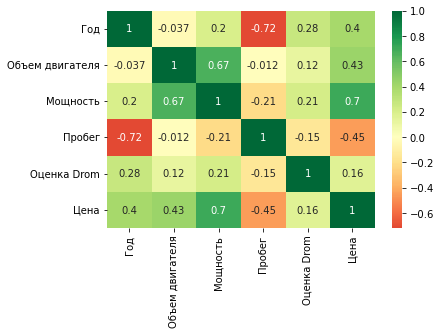

In [89]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True);

Отлично! Наиболее яркими зависимостями получились: Объем двигателя и мощность, год выпуска и пробег, мощность двигателя и цена. Первые две вполне легко объяснимы: чем больше у двигателя объем, тем большую мощность он способен выдать и чем раньше был выпущен автомобиль - тем дольше и дальше он катается по дорогам. Посмотрим на них на наличие всяких интересностей. 

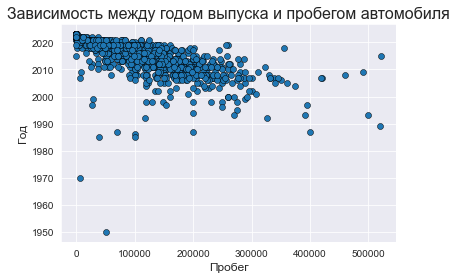

In [90]:
sns.set_style('darkgrid')
plt.title('Зависимость между годом выпуска и пробегом автомобиля',size=16)
plt.xlabel('Пробег',size=12)
plt.ylabel('Год',size=12)
sns.scatterplot(x='Пробег', y='Год', data=df, edgecolor='black', palette='cubehelix')
plt.show() 

Взаимосвязь отрицательная: чем меньше год выпуска, тем больше пробег. Очень логично.

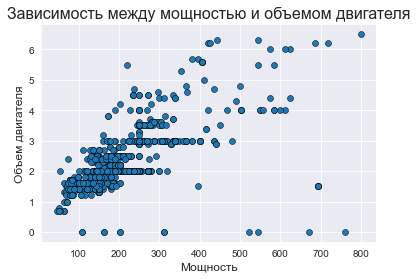

In [91]:
plt.title('Зависимость между мощностью и объемом двигателя',size=16)
plt.xlabel('Мощность',size=12)
plt.ylabel('Объем двигателя',size=12)
sns.scatterplot(x='Мощность', y='Объем двигателя', data=df, edgecolor='black', palette='cubehelix')
plt.show()

Можно заметить, что подавляющее большинство составляют новые автомобили с относительно небольшим пробегом, а так же автомобили с относительно невысокой мощностью. Вероятно, это особновано тем, что подавляющее большинство используемых автомобилей - легковые, которые владелец собирается менять на аналогичные, но более новые марки. 

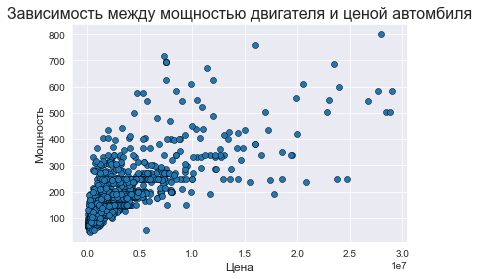

In [92]:
plt.title('Зависимость между мощностью двигателя и ценой автомбиля',size=16)
plt.xlabel('Цена',size=12)
plt.ylabel('Мощность',size=12)
sns.scatterplot(x='Цена', y='Мощность', data=df, edgecolor='black', palette='cubehelix')
plt.show()

Схожее распределение, показывающее что большинство автомобилей - относительно слабые и дешевые. 

Помимо подавляющего большинства на графиках выше также хорошо заметны единичные случаи сильных, дорогих или старых автомобилей. 

Хорошо, с численными переменными все стало немного понятнее. Но что со всем остальным?

In [93]:
df.describe(include='object')

,Название,Топливо,Коробка передач,Привод,Цвет,Руль
count,1370,1370,1370,1370,1370,1370
unique,404,3,4,3,15,2
top,Kia Rio,бензин,автомат,передний,белый,левый
freq,30,1087,833,653,463,1321


Если с большей частью столбцов все было понятно еще на этапе обработки данных, то вот узнать, сколько различных марок машин сейчас продается и какая из них самая популярная достаточно интересно.

Но что если рассматривать по производителям и конкретным моделям?

In [94]:
data2 = pd.DataFrame()
data2[['Производитель', 'Модель']] = df['Название'].str.split(' ', 1, expand=True)
data2

,Производитель,Модель
0,Kia,Mohave
1,Hyundai,Santa Fe
2,Toyota,RAV4
3,Jeep,Gladiator
4,Jeep,Wrangler
...,...,...
1365,Volvo,XC60
1366,Audi,A8
1367,BMW,3-Series
1368,Geely,Tugella FY11


> Как видно, даже отделив Kia от Rio, они все равно остаются самыми популярными среди производителей и моделей соответственно 

In [95]:
data2.describe()

,Производитель,Модель
count,1370,1370
unique,66,404
top,Kia,Rio
freq,148,30


In [4]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

# IV) Создаем новый признак

Для того чтобы определить страну производитель, было решено сначала разделить название на производителя и модель в исходном датасете, затем глянуть на производителей и создать словарь с производителями и странами

In [2]:
df = pd.read_csv('data_processed.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df.insert(1, 'Марка', df['Название'].str.split(' ', 1, expand=True)[1])
df['Название'] = df['Название'].str.split(' ', 1, expand=True)[0]
df.rename(columns = {'Название': 'Производитель'}, inplace = True)

Путем поиска в интернетах создаем словарик...

In [4]:
slovar = {'Kia': 'Южная Корея', 'Hyundai': 'Южная Корея', 'Toyota': 'Япония', 'Jeep': 'США',
          'Mercedes-Benz': 'Германия', 'Лада': 'Россия', 'BMW': 'Германия','ГАЗ': 'Россия',
          'Changan': 'Китай', 'Infiniti': 'Япония', 'Audi': 'Германия', 'Volkswagen': 'Германия',
          'Great Wall': 'Китай', 'Honda': 'Япония', 'Nissan': 'Япония', 'SsangYong': 'Южная Корея', 
          'Skoda': 'Чехия', 'Volvo': 'Швеция', 'Land Rover': 'Британия', 'Chevrolet': 'США',
          'Mazda': 'Япония', 'Opel': 'Германия', 'Peugeot': 'Франция', 'Rivian': 'США',
          'Renault': 'Франция', 'Mitsubishi': 'Япония', 'Tesla': 'США', 'Lexus': 'Япония',
          'Ford': 'США', 'Bentley': 'Британия', 'Subaru': 'Япония', 'Porsche': 'Германия',
          'Dodge': 'США', 'Fiat': 'Италия', 'Suzuki': 'Япония', 'Haval': 'Китай', 'УАЗ': 'Россия',
          'Geely': 'Китай', 'Chery': 'Китай', 'EXEED': 'Китай', 'Genesis': 'Южная Корея',
          'Dongfeng': 'Китай', 'Citroen': 'Германия', 'BYD': 'Китай', 'Jaguar': 'Британия',
          'Tank': 'Китай', 'ЗАЗ': 'Россия', 'Daewoo': 'Южная Корея', 'Kaiyi': 'Китай',
          'MINI': 'Британия', 'Datsun': 'Япония', 'Москвич': 'Россия', 'SEAT': 'Испания',
          'Cadillac': 'США', 'Daihatsu': 'Япония', 'Voyah': 'Китай', 'GMC': 'США', 'Chrysler': 'США',
          'Lifan': 'Китай', 'Isuzu': 'Япония', 'Ferrari': 'Италия', 'Smart': 'Германия',
          'Evolute': 'Россия', 'RAM': 'США', 'Maybach': 'Германия'}

Во время сбора словарика были найдены производители с названием из двух и более слов: Land Rover, Great Wall. Заменим их модели и название производителей.

Более того, была найдена машина Jetta совместного производства Китая и Volkswagen. Так как это пилотный проект, то было решено вообще выкинуть этот мусор

In [5]:
df.set_index('Производитель', inplace=True)
df.drop('Jetta', inplace=True)
df.rename(index = {'Great': 'Great Wall', 'Land': 'Land Rover'}, inplace=True)
df.reset_index(inplace = True)

for i in df[df['Производитель'] == 'Land Rover']['Марка'].values:
    df.replace(i, i.replace('Rover ', '', 1), inplace=True)
    
for i in df[df['Производитель'] == 'Great Wall']['Марка'].values:
    df.replace(i, i.replace('Wall ', '', 1), inplace=True)

countries = []
for i in list(df['Производитель'].values):
    countries.append(slovar[i])
df.insert(2, 'Страна', countries)


In [6]:
df.to_csv('new_data_processed.csv')

# V) Проверка гипотез

## Среднее значение цен на западные автомобили равно среднему значению цен на восточные

Приступим к проверке гипотезы. То есть:

$$
\begin{aligned}
&H_0:  \mu(восток)\ = \mu(запад)\\
&H_1:  \mu(восток)\ \not=\ \mu(запад)\\
\end{aligned}
$$

Рассмотрим, что относится к западу и востоку

In [7]:
df['Страна'].unique()

array(['Южная Корея', 'Япония', 'США', 'Германия', 'Россия', 'Китай',
       'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'],
      dtype=object)

In [8]:
west = np.array(['США', 'Германия', 'Чехия', 'Швеция', 'Британия', 'Франция', 'Италия', 'Испания'])
east = ['Южная Корея', 'Япония', 'Россия', 'Китай']

Проверим распределение цен автомобилей

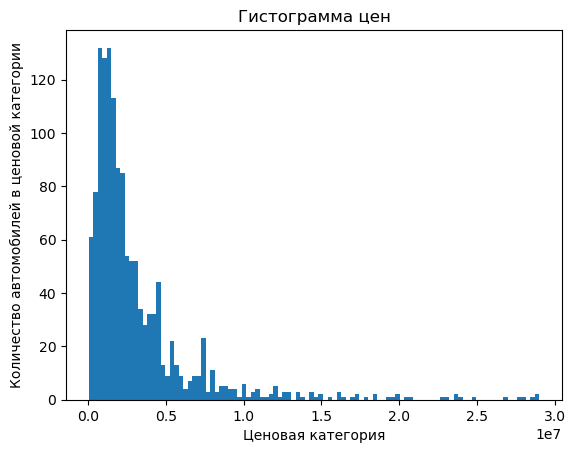

In [9]:
plt.hist(df['Цена'], bins=100)
plt.title('Гистограмма цен')
plt.xlabel('Ценовая категория')
plt.ylabel('Количество автомобилей в ценовой категории');

Гистограмма очень похожа на хи квадрат, который в ассимптотике сможет дать нормальное распределение, поэтому воспользуюсь этим свойством для проверки гипотезы.

Я не знаю истинную дисперсию, поэтому воспользовался ее несмещенной оценкой..

Рассматривался уровень доверия 95%

In [10]:
idx_w = []
idx_e = []
for i in df['Страна']:
    if i in west:
        idx_w.append(True)
        idx_e.append(False)
    else:
        idx_w.append(False)
        idx_e.append(True)

df_w = df[idx_w]
df_e = df[idx_e]

sigma = np.sqrt((df_e['Цена'].var(ddof=1) * (df_e.size - 1) + df_w['Цена'].var(ddof=1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)


In [11]:
sigma = np.sqrt((df_e['Цена'].var(ddof=1) * (df_e.size - 1) + df_w['Цена'].var(ddof=1) * (df_w.size - 1)) 
 / (df_w.size + df_e.size - 2))

t_rasch = (df_w['Цена'].mean() - df_e['Цена'].mean()) / (sigma * np.sqrt((1 / df_e.size) + (1 / df_w.size)))
t_kr = sts.t(df = df_e.size + df_w.size - 2).ppf(0.05/2)

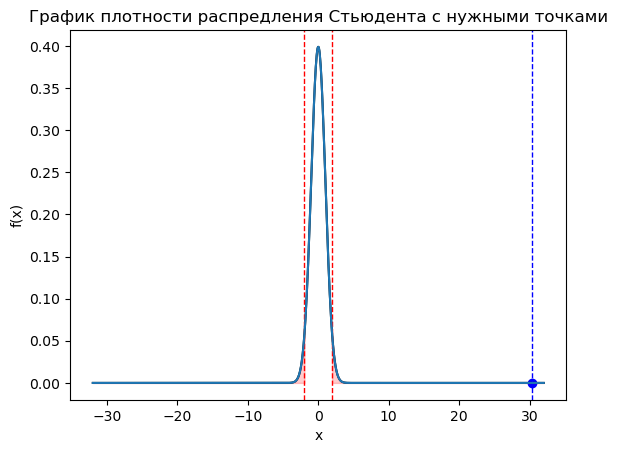

In [12]:
x = np.linspace(-32, 32, 1000)
pdf = sts.t(df=df_e.size + df_w.size - 2).pdf(x)
plt.plot(x, pdf, color = 'black')

plt.scatter(t_rasch, [sts.t(df=df_e.size + df_w.size - 2).pdf(t_rasch)], color="blue")
plt.axvline(t_rasch, color='blue', linestyle="--", lw=1)

plt.axvline(t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-32, t_kr, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.axvline(-1 * t_kr, color='red', linestyle="--", lw=1)
xq = np.linspace(-1 * t_kr, 32, 100)
yq = sts.t(df=df_e.size + df_w.size - 2).pdf(xq)
plt.fill_between(xq, 0, yq, color='red', alpha=0.2)

plt.plot(x, pdf)
plt.ylabel('f(x)')
plt.xlabel('x')
plt.title('График плотности распредления Стьюдента с нужными точками');

In [13]:
print('Расчетная точка:',  t_rasch)
print('Критические точки: ',  -1 * t_kr, ', ', t_kr, sep='')

Расчетная точка: 30.34321831511047
Критические точки: 1.960087961271559, -1.960087961271559


Собственного говоря, гипотеза отвергается. Это видно и по графику выше

> Гипотез много. Например, выше, во время обработки данных и EDA я заметил раритетную машину 1950 года. Интересно, она одна такая? Или их значимое количество, если поискать? 

## Может ли цена зависеть от года выпуска прямо - чем меньше год выпуска, т.е. старее машина - тем выше цена?

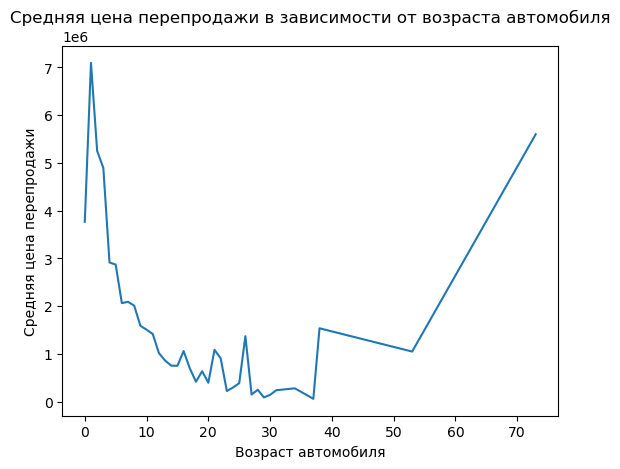

In [14]:
df['Год'] = pd.to_numeric(df['Год'])

# Создание нового столбца 'Возраст'
current_year = 2023  # Текущий год
df['Возраст'] = current_year - df['Год']

# Группировка данных по возрасту автомобилей и вычисление средней цены для каждой группы
age_price = df.groupby('Возраст')['Цена'].mean()

# Построение графика для визуализации результатов
plt.plot(age_price.index, age_price.values)
plt.xlabel('Возраст автомобиля')
plt.ylabel('Средняя цена перепродажи')
plt.title('Средняя цена перепродажи в зависимости от возраста автомобиля')
plt.show()

In [15]:
df.loc[df.Возраст > 35].head()

,Производитель,Марка,Страна,Год,Топливо,Объем двигателя,Мощность,Коробка передач,Привод,Цвет,Пробег,Руль,Оценка Drom,Цена,Возраст
12,ГАЗ,14 Чайка,Россия,1985,бензин,5.5,220.0,автомат,задний,черный,39316.0,левый,8.602,3000000,38
161,Лада,2101,Россия,1986,бензин,1.3,64.0,механика,задний,бежевый,100000.0,левый,7.500,60000,37
543,Лада,4x4 2121 Нива,Россия,1987,бензин,1.6,73.0,механика,4WD,бежевый,69000.0,левый,8.602,152000,36
548,Лада,2102,Россия,1985,бензин,1.6,64.0,механика,задний,бежевый,99999.0,левый,8.602,75000,38
885,BMW,340,Германия,1950,бензин,2.0,55.0,механика,задний,черный,50000.0,левый,8.602,5600000,73


> Что ж, немолодых автомобилей оказалось не так много, как хотелось бы, но учитывая, что на 3 машины из 5 имеющихся возрастом сташе 35 лет стоимость больше миллиона и на графике четко видно, что она растет с возрастом - данная зависимость имеет место быть.

Хорошо, но можно ли говорить, что цена автомобиля обусловлена его возрастом, пробегом и прочими факторами, но при этом в целом не так то и важно, какая марка машины это изначально была?

In [16]:
brand_price = df.groupby('Производитель')['Цена'].mean()

# Выполнение однофакторного ANOVA
fvalue, pvalue = sts.f_oneway(*[group['Цена'] for brand, group in df.groupby('Производитель')])

# Вывод результатов
print("F-значение:", fvalue)
print("p-value:", pvalue)

F-значение: 12.02950298125449
p-value: 9.934432508238841e-92


Кажется, нет. Из-за большого F-значения можно утверждать, что марка авто значительно влияет на его цену, а столь маленький p-value (e-92!!!!) говорит о том, что ошибка тут явно исключена

# VI) Построение моделей

Модели будут предсказывать цену автомобиля

## Линейная регрессия

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from catboost import Pool, cv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

In [44]:
def rmse_score(true, pred):
    return np.sqrt(mean_squared_error(true, pred))

In [45]:
df = pd.read_csv('new_data_processed.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [46]:
#Только числовые немасштабированные данные 

df_1 = df[['Год', 'Объем двигателя', 'Мощность', 'Пробег', 'Оценка Drom', 'Цена']]
df_train, df_test = train_test_split(df_1, test_size=0.2, random_state=101)

y_train_num = df_train['Цена']
y_test_num = df_test['Цена']

X_train_num = df_train.drop('Цена', axis=1)
X_test_num = df_test.drop('Цена', axis=1)

X_num = df_1.drop('Цена', axis=1)
y_num = df_1['Цена']

In [47]:
#Масштабированные числовые признаки

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_num)
X_test_scale = scaler.transform(X_test_num)

In [48]:
#Категориальные признаки

numeric_features = df.select_dtypes([np.number]).columns
categorical_features = df.dtypes[df.dtypes == "object"].index

encoder = OneHotEncoder(drop="first", sparse=False, handle_unknown='ignore')
df_cat_ohe = pd.DataFrame(encoder.fit_transform(df[categorical_features]), 
                          columns = encoder.get_feature_names_out(categorical_features))

df_all = pd.concat([df[numeric_features], df_cat_ohe], axis = 1)

df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=101)

y_train_cat = df_train['Цена']
y_test_cat = df_test['Цена']

X_train_cat = df_train.drop('Цена', axis=1)
X_test_cat = df_test.drop('Цена', axis=1)

X_cat = df_all.drop('Цена', axis = 1)
y_cat = df_all['Цена']

### Классическая линейная регрессия

In [49]:
model = LinearRegression()

model.fit(X_train_num, y_train_num)
y_pr = model.predict(X_test_num)
y_train_pred = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pred))

cross_val = cross_val_score(model, X_num, y_num, scoring='neg_root_mean_squared_error')
rmse = np.mean(-1 * cross_val)
print("\nRMSE cross_val:", rmse)

Test RMSE = 2449187.3553
Train RMSE = 2385901.7710

RMSE cross_val: 2412789.0238631465


__Наивный прогноз__

In [50]:
y_naive_pred = np.mean(y_train_num) * np.ones_like(y_test_num)
rmse_score(y_naive_pred, y_pr)

2790260.307230077

Модель предсказывает лучше, чем наивный проноз, но метрики все равно плохи...

### Отмасштабированная линейная регрессия

In [51]:
model.fit(X_train_scale, y_train_num)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_ss))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pr_ss))


simple_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('regression', LinearRegression())
])

scores = cross_val_score(simple_pipeline, X_num, y_num, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 2449187.3553
Train RMSE = 2385901.7710

RMSE cross_val: 2412789.023863147


Скалирование ничего не изменило... Добавим категориальные признаки

### Линейная регрессия с категориальными признаками

In [52]:
Linear_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', LinearRegression())
])

model = Linear_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model.predict(X_test_cat)
y_train_pred = model.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))


scores = cross_val_score(Linear_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 299902269852520087552.0000
Train RMSE = 2653830.2554

RMSE cross_val: 1.8642591168004784e+20


Так как категориальные переменные раздули донельзя датасет, применим Lasso - регрессию, чтобы выбросить "плохие" признаки

### Регуляризация

In [53]:
Lasso_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso())
])

model_lasso = Lasso_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model_lasso.predict(X_test_cat)
y_train_pred = model_lasso.predict(X_train_cat)


print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))


scores = cross_val_score(Lasso_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 2441961.4014
Train RMSE = 1466213.1635

RMSE cross_val: 2341549.334979023


Лассо помогло снизить переобучение. Попробуем подобрать альфу через гридсерч

In [54]:
alphas = np.linspace(0, 1, 20)
searcher = GridSearchCV(Lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=5)
searcher.fit(X_train_cat, y_train_cat)

best_alpha = searcher.best_params_["regression__alpha"]

pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('regression', Lasso(best_alpha))
])

model_lasso = pipeline.fit(X_train_cat, y_train_cat)
y_pred = model_lasso.predict(X_test_cat)
y_train_pred = model_lasso.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))
print('\nBest alpha:', best_alpha)
print('\nRMSE cross_cal', -1 * searcher.best_score_)

Test RMSE = 2441961.4014
Train RMSE = 1466213.1635

Best alpha: 1.0

RMSE cross_cal 2324897.95705208


In [55]:
print('Число ненужных параметров:', 
      sum(model_lasso['regression'].coef_ == 0), 'из', 
      len(model_lasso['regression'].coef_))

Число ненужных параметров: 61 из 503


In [133]:
best_par = X_train_cat.columns[model_lasso['regression'].coef_ == model_lasso['regression'].coef_.max()][0]
print(f'Наиболее важный параметр: {best_par}')

Наиболее важный параметр: Мощность


Закончим с регрессиями и посмотрим на другие модели

## Метод ближайших соседей

### Классический kNN

In [56]:
model = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')

model.fit(X_train_num, y_train_num)
y_pr = model.predict(X_test_num)
y_train_pred = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pred))

cross_val = cross_val_score(model, X_num, y_num, scoring='neg_root_mean_squared_error')
rmse = np.mean(-1 * cross_val)
print("\nRMSE cross_val:", rmse)

Test RMSE = 3000269.6268
Train RMSE = 221365.3099

RMSE cross_val: 2868906.9510235693


Проделаем все, что делали выше для линейной регрессии

### kNN со скалированными данными

In [57]:
model.fit(X_train_scale, y_train_num)
y_pr_ss = model.predict(X_test_scale)
y_train_pr_ss = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_ss))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_train_pr_ss))

X = df_1.drop('Цена', axis=1)
y = df_1['Цена']

knn_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=10, p=2, weights='distance'))
])

scores = cross_val_score(knn_pipeline, X_num, y_num, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 1793132.9592
Train RMSE = 221365.3099

RMSE cross_val: 1891642.1446624529


Очевидно, стандартизация очень сильно помогла ближайшим соседям. Попробую добавить категориальные переменные

### kNN с категориальными данными

In [58]:
KNN_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train_cat, y_train_cat)
y_pred = model.predict(X_test_cat)
y_train_pred = model.predict(X_train_cat)

print("Test RMSE = %.4f" % rmse_score(y_test_cat, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train_cat, y_train_pred))

scores = cross_val_score(KNN_pipeline, X_cat, y_cat, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 3428668.4866
Train RMSE = 2002061.4075

RMSE cross_val: 3024650.136194841


Уберем лишние признаки согласно модели Lasso

In [59]:
df_lasso = pd.concat([X_cat[X_cat.columns[model_lasso['regression'].coef_ != 0]], y], axis = 1)

df_train, df_test = train_test_split(df_lasso, test_size=0.2, random_state=101)

y_train = df_train['Цена']
y_test = df_test['Цена']

X_train = df_train.drop('Цена', axis=1)
X_test = df_test.drop('Цена', axis=1)

KNN_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('KNN', KNeighborsClassifier(2))
])

model = KNN_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pred))
print("Train RMSE = %.4f" % rmse_score(y_train, y_train_pred))

scores = cross_val_score(KNN_pipeline, df_lasso, y, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 3428668.4866
Train RMSE = 2058974.0689

RMSE cross_val: 2384687.502201992


## Случайный лес

Так как не имеет смысла рассматривать все наборы признаков, оставим два наиболее логичных:
- Числовые отмасштабированные признаки;
- Числовые отмасштабированные признаки + отобранные закодированные категориальные признаки


Как известно, решающее дерево и случайный лес могут принимать на вход незакодированные категориальные признаки, однако в таком случае будет несколько больше сплитов. Чтобы ускорить процесс обучения, будем подавать закодированные признаки

### Модель с отскалированными числовыми признаками

In [26]:
rfr_pipeline = Pipeline(steps=[
    ('SS', StandardScaler()),
    ('RFR', RandomForestRegressor(random_state=42))
])

params = {'RFR__n_estimators': np.arange(1, 20, 3),
          'RFR__criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
          'RFR__max_depth': np.arange(1, 36, 1)}

grid = GridSearchCV(rfr_pipeline, param_grid=params, scoring='neg_root_mean_squared_error', cv = 5)
grid.fit(X_train_num, y_train_num)
print(f'RMSE {-1 * grid.best_score_}')

RMSE 1513019.9060417782


In [39]:
model = grid.best_estimator_
model.fit(X_train_scale, y_train_num)

y_pr_test = model.predict(X_test_scale)
y_pr_train = model.predict(X_train_scale)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_pr_train))

Test RMSE = 1686771.7154
Train RMSE = 708091.3885


### Модель с категориальными признаками

In [115]:
RFR_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('RFR', model)
])

RFR_pipeline.fit(X_train, y_train_cat)

y_pr_test = RFR_pipeline.predict(X_test)
y_pr_train = RFR_pipeline.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train, y_pr_train))

scores = cross_val_score(RFR_pipeline, df_lasso, y, scoring='neg_root_mean_squared_error', cv=5)
rmse = np.mean(-1 * scores)

print("\nRMSE cross_val:", rmse)

Test RMSE = 1440099.9345
Train RMSE = 637070.9761

RMSE cross_val: 179393.34077576734


Категориальные признаки только ухудшили качество модели и степень переобучения, поэтому для деревьев оказался более полезным числовой набор признаков, более того эта модель лучшая из рассмотренных ранее

## Градиентный бустинг

### Модель с числовыми признаками 

In [100]:
model = CatBoostRegressor(iterations=10000, 
                          depth=2, 
                          learning_rate=0.01, 
                          loss_function='RMSE',
                          verbose=False)

model.fit(X_train_num, y_train_num)

y_pr_test = model.predict(X_test_num)
y_pr_train = model.predict(X_train_num)

print("Test RMSE = %.4f" % rmse_score(y_test_num, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train_num, y_pr_train))

cv_num = cv(pool=Pool(X_num, label=y_num),
                      params=model.get_params(), 
                      fold_count=5,
                      verbose=False)

rmse = cv_num['test-RMSE-mean']

print("CV RMSE = %.4f" % np.mean(rmse))

Test RMSE = 1655363.9973
Train RMSE = 934453.8240
Training on fold [0/5]

bestTest = 1425080.727
bestIteration = 4561

Training on fold [1/5]

bestTest = 1602002.948
bestIteration = 2811

Training on fold [2/5]

bestTest = 1511538.864
bestIteration = 9962

Training on fold [3/5]

bestTest = 1547572.772
bestIteration = 7960

Training on fold [4/5]

bestTest = 1425730.057
bestIteration = 4895

CV RMSE = 1602154.2970


### Модель с категориальными признаками

In [116]:
model = CatBoostRegressor(iterations=10000, 
                          depth=2, 
                          learning_rate=0.01, 
                          loss_function='RMSE',
                          verbose=False)

model.fit(X_train, y_train)

y_pr_test = model.predict(X_test)
y_pr_train = model.predict(X_train)

print("Test RMSE = %.4f" % rmse_score(y_test, y_pr_test))
print("Train RMSE = %.4f" % rmse_score(y_train, y_pr_train))

cv_cat = cv(pool=Pool(df_lasso, label=y),
                      params=model.get_params(), 
                      fold_count=5,
                      verbose=False)

rmse = cv_cat['test-RMSE-mean']

print("CV RMSE = %.4f" % np.mean(rmse))

Test RMSE = 1440082.6574
Train RMSE = 637070.9761
Training on fold [0/5]

bestTest = 182670.3485
bestIteration = 9997

Training on fold [1/5]

bestTest = 111542.6492
bestIteration = 7472

Training on fold [2/5]

bestTest = 130930.112
bestIteration = 1004

Training on fold [3/5]

bestTest = 113707.3042
bestIteration = 9970

Training on fold [4/5]

bestTest = 144773.3641
bestIteration = 5915

CV RMSE = 211657.7678


Модель на тестовой и тренировочной выборках показала примерно аналогичный результат, как и лес на более важных признаках, однако RMSE на кросс-валидации оказался меньше в разы.

# Выводы

Большинство выводов было сделано в ходе исследования.

Лучшая модель на данный момент исследования оказался лес со скалированными числовыми признаками. Его метрики:
- Test RMSE = 1686771.7154		
- Train RMSE = 708091.3885		
		
- CV RMSE 1513019.9060

Очевидно, что это довольно большие значения для задачи, однако это объясняется свойствами данных. В датасете представлены, как раритетные автомобили с большими ценами (что не может быть просто объяснено моделями), так и автомобили премиум-сегмента, которые по свойствам могут не отличаться от более дешевых аналогов

# Будущее

В дальнейшем хочется разбить датасет на некоторые категории автомобилей (премиум-сегмент, раритетное авто и т.д.), вероятнее всего, это будет сделано с помощью решающего дерева или ансамбля. 

Работа с такими категорями должна кратно улучшить метрики за счет создания сразу нескольких моделей под каждую категорию. 

Кроме этого в планах разработать полносвязную нейронную сеть для набора данных